# 识别计算跳跃收益

## 导入模块

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import feather
import math
from scipy import stats
from tqdm.notebook import tqdm
import os
%load_ext line_profiler
matplotlib.use('Agg')

## 读入测试数据

In [2]:
price_1m = feather.read_dataframe('../data/StockPriceK1m/2024/StockPriceK1m_20240820.feather')
price_1m['date'] = pd.to_datetime(price_1m['date'].astype(str))
price_1d = feather.read_dataframe('../data/StockPriceK1d_20241231.feather')
price_1d['date'] = pd.to_datetime(price_1d['date'])

## 处理筛选日线数据

剔除上市不足 180 天、停牌、涨停股票

In [3]:
# def IPO_time(price_1d, timedelta='180D'):
#     start_date = price_1d['date'].min()
#     idx_ipo = price_1d['date'] >= start_date + pd.Timedelta(timedelta)
#     return price_1d[idx_ipo]

# price_1d = price_1d.groupby('issue').apply(IPO_time)
# price_1d = price_1d[(~price_1d['is_limit_buy'].astype(bool)) & (~price_1d['is_limit_sell'].astype(bool))]

In [4]:
idx_date = (price_1d['date'] >= '2018-12-28') & (price_1d['date'] <= '2024-12-31')
price_1d = price_1d[idx_date]
price_1d = price_1d.set_index(['issue', 'date'])

## 定义跳跃统计量

In [5]:
def mu(p: float):
    return (2 ** (p / 2)) * math.gamma((p + 1) / 2) / np.sqrt(np.pi)

mu1 = mu(1)
mu6 = mu(6)

def JS(ret, log_ret):
    n_series, n_points = ret.shape
    abs_log_ret = np.abs(log_ret)
    
    window_size = 6
    windows = np.lib.stride_tricks.sliding_window_view(
        abs_log_ret, window_shape=window_size, axis=1
    )
    prod_6 = np.prod(windows, axis=-1)
    sum_prod_6 = np.sum(prod_6, axis=1)
    coef_Omega = (mu6 / 9) * ((n_points ** 3) * (mu1 ** -6) / (n_points - 5))
    Omega_SwV = coef_Omega * sum_prod_6
    
    window_size_2 = 2
    windows_2 = np.lib.stride_tricks.sliding_window_view(
        abs_log_ret, window_shape=window_size_2, axis=1
    )
    prod_2 = np.prod(windows_2, axis=-1)
    sum_prod_2 = np.sum(prod_2, axis=1)
    coef_V = 1 / (mu1 ** 2)
    V_01 = coef_V * sum_prod_2
    
    RV_N = np.sum(log_ret ** 2, axis=1)
    SwV_N = 2 * np.sum(ret - log_ret, axis=1)
    
    valid_mask = (Omega_SwV != 0) & (SwV_N != 0)
    js = np.full(n_series, np.nan)
    if np.any(valid_mask):
        valid_idx = np.where(valid_mask)[0]
        js[valid_idx] = n_points * (V_01[valid_idx] / np.sqrt(Omega_SwV[valid_idx])) * (1 - RV_N[valid_idx] / SwV_N[valid_idx])
    
    return js[0] if n_series == 1 else js

def pvalue(js: float):
    cdf = stats.norm.cdf(js, loc=0, scale=1)
    return 2 * min(cdf, 1 - cdf)

In [6]:
def JS2(ret, log_ret):
    n = len(ret)
    abs_log_ret = np.abs(log_ret)
    
    coef_Omega = (mu6 / 9) * ((n ** 3) * (mu1 ** -6) / (n - 5))
    prod_6 = (
        abs_log_ret[:-5] * 
        abs_log_ret[1:-4] * 
        abs_log_ret[2:-3] * 
        abs_log_ret[3:-2] * 
        abs_log_ret[4:-1] * 
        abs_log_ret[5:]
    )
    sum_prod_6 = prod_6.sum()
    Omega_SwV = coef_Omega * sum_prod_6
    
    coef_V = 1 / (mu1 ** 2)
    prod2 = abs_log_ret[:-1] * abs_log_ret[1:]
    sum_prod_2 = prod2.sum()
    V_01 = coef_V * sum_prod_2
    
    RV_N = (log_ret * log_ret).sum()
    SwV_N = 2 * (ret - log_ret).sum()

    print(f'V_01 = {V_01}')
    print(f'Omage_SwV = {Omega_SwV}')
    print(f'RV_N = {RV_N}')
    print(f'SwV_N = {SwV_N}')
    print(f'V_01 / np.sqrt(Omega_SwV) = {V_01 / np.sqrt(Omega_SwV)}')
    print(f'1 - (RV_N / SwV_N) = {1 - (RV_N / SwV_N)}')
    print(f'JS = {n * (V_01 / np.sqrt(Omega_SwV)) * (1 - (RV_N / SwV_N))}')
    plt.plot(log_ret)
    plt.gca().set_box_aspect(0.5)
    plt.show()
    if (Omega_SwV != 0) and (SwV_N != 0):
        return n * (V_01 / np.sqrt(Omega_SwV)) * (1 - (RV_N / SwV_N))
    else:
        return np.nan

## 识别跳跃, 计算收益

In [7]:
def jump_identify(ret, log_ret, method='abs_sub', plot=False):
    n = len(ret)
    jump = np.full(n, False, dtype=bool)
    # med = np.median(ret)
    # log_med = np.median(log_ret)
    ret_c = ret.copy()
    log_ret_c = log_ret.copy()
    js0 = JS(ret_c.reshape(1, n), log_ret_c.reshape(1, n))
    p = pvalue(js0)
    js0_pre = js0
    
    while (p < 0.05):
        med = np.median(ret_c)
        log_med = np.median(log_ret_c)
        
        ret_mat = np.tile(ret_c, (n, 1))
        log_ret_mat = np.tile(log_ret_c, (n, 1))
        np.fill_diagonal(ret_mat, med)
        np.fill_diagonal(log_ret_mat, log_med)
        js = JS(ret_mat, log_ret_mat)

        if method == 'abs_sub':
            js_diff = np.abs(js0) - np.abs(js)
        elif method == 'sub_abs':
            js_diff = np.abs(js0 - js)
        elif method == 'sub':
            js_diff = js0 - js
        idx_max = np.nanargmax(js_diff)
        jump[idx_max] = True
        ret_c[idx_max] = med
        log_ret_c[idx_max] = log_med
        js0 = JS(ret_c.reshape(1, n), log_ret_c.reshape(1, n))
        p = pvalue(js0)
        if js0 == js0_pre:
            break
        js0_pre = js0

    if plot:
        ax0 = plt.gcf().axes[0]
        ax1 = plt.gcf().axes[1]
        for i in range(len(jump)):
            if jump[i]:
                color = 'red' if log_ret[i] >= 0 else 'green'
                ax0.axvspan(i - 0.5, i + 0.5, color=color, alpha=0.5)
                ax1.axvspan(i - 0.5, i + 0.5, color=color, alpha=0.5)

    ret_jump = log_ret[jump].sum()
    ret_nojump = log_ret[~jump].sum()
    ret_posjump = log_ret[jump & (log_ret > 0)].sum()
    ret_negjump = log_ret[jump & (log_ret < 0)].sum()
    return np.any(jump), jump.sum(), ret_jump, ret_nojump, ret_posjump, ret_negjump

In [8]:
time_start = np.append(np.arange(93000, 113000, 500), np.arange(130000, 150000, 500))
time_start = time_start[np.where(time_start % 10000 < 6000)]
time_end = time_start[1:]

def jump_identify_price(price_1m, price_1d, date, date_prev, method='abs_sub', plot=False, dirname=None):
    issue = price_1m.iloc[0]['issue']
    prc = price_1m.copy()
    start_price = prc.loc[prc['time'].isin(time_start), 'open'].to_numpy()
    end_price = prc.loc[prc['time'].isin(time_end), 'open'].to_numpy()
    end_price = np.append(end_price, prc.iloc[-1]['close'])

    try:
        adj_today = price_1d.loc[(issue, date), 'adj']
        adj_prev = price_1d.loc[(issue, date_prev), 'adj']
        start_price *= adj_today
        end_price *= adj_today
        open_today = price_1d.loc[(issue, date), 'open'] * adj_today
        close_prev = price_1d.loc[(issue, date), 'preclose'] * adj_prev
    except KeyError:
        df_jump = pd.DataFrame({
            'issue': [issue], 'date': [date], 'jump': [False], 'jump_count': [0], 'ret_jump': [0.],
            'ret_nojump': [0.], 'ret_posjump': [0.], 'ret_negjump': [0.]
        })
        return df_jump
        
    start_price = np.insert(start_price, 0, close_prev)
    end_price = np.insert(end_price, 0, open_today)
    
    ret = (end_price - start_price) / start_price
    log_ret = np.log(1 + ret)

    if plot:
        fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True)
        fig.subplots_adjust(hspace=0)
        rise = end_price > start_price
        colors = np.where(rise, 'red', 'green')
        ax0.bar(x=range(len(start_price)), height=end_price-start_price, bottom=start_price, color=colors)
        ax0.set_ylabel('Price_hfq')
        ax1.plot(log_ret)
        ax1.set_ylabel('Ret')
        xticks = np.insert((time_start[1::2] / 100).astype(int).astype(str), 0, 'yesterday')
        plt.xticks(np.arange(0, 49, 2), xticks, rotation=90)
        plt.xlabel('Time')
        date_str = date.strftime('%Y%m%d')
        fig.suptitle(f'price, rets, and jumps in stock {issue} {date_str}')

    flag_jump, jump_count, ret_jump, ret_nojump, ret_posjump, ret_negjump = jump_identify(ret, log_ret, method, plot)

    if plot:
        if dirname != None:
            plt.savefig(dirname + f'/{issue}_{date_str}.png')
            plt.close()
        else:
            plt.show()
        plt.cla()
        plt.clf()
        plt.close("all")
            
    df_jump = pd.DataFrame({
        'issue': [issue], 'date': [date], 'jump': [flag_jump], 'jump_count': [jump_count], 'ret_jump': [ret_jump],
        'ret_nojump': [ret_nojump], 'ret_posjump': [ret_posjump], 'ret_negjump': [ret_negjump]
    })
    return df_jump

def jump_identify_parallel(price_1m, price_1d, date):
    groups = list(price_1m.groupby('issue'))
    total_groups = len(groups)
    
    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(jump_identify_price)(group[1], price_1d, '2024-01-02', '2024-01-03')
        for group in tqdm(groups, total=total_groups, desc="Processing stocks")
    )
    
    return pd.concat(results)

## 画图检查

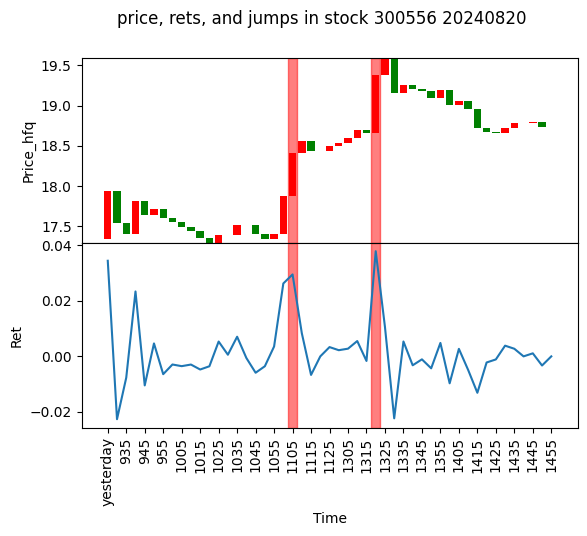

,issue,date,jump,jump_count,ret_jump,ret_nojump,ret_posjump,ret_negjump
0,300556,2024-08-20,True,2,0.067435,0.010274,0.067435,0.0


In [9]:
# issues_tocheck = ['300556', '001288', '001360', '002434', '002625', '002795', '002797', '002801', '003026', '300016']
issue = '300556'
date = pd.to_datetime('2024-08-20')
date_prev = pd.to_datetime('2024-08-19')
year = date.year
date_str = date.strftime('%Y%m%d')
price_1m = feather.read_dataframe(f'../data/StockPriceK1m/{year}/StockPriceK1m_{date_str}.feather')

%matplotlib inline
jump_identify_price(
    price_1m=price_1m[price_1m['issue'] == issue],
    price_1d=price_1d,
    date=date, date_prev=date_prev,
    plot=True
)

In [10]:
# # issues_tocheck = ['300556', '001288', '001360', '002434', '002625', '002795', '002797', '002801', '003026', '300016']
# date = pd.to_datetime('2024-08-20')
# year = date.year
# date_str = date.strftime('%Y%m%d')
# price_1m = feather.read_dataframe(f'../data/StockPriceK1m/{year}/StockPriceK1m_{date_str}.feather')

# dirname = '../data/jump_plot/sub/'
# os.makedirs(dirname, exist_ok=True)
# df_jump_abs_sub = price_1m.groupby('issue')[['issue', 'time', 'open', 'close']].apply(
#     jump_identify_price,
#     price_1d=price_1d,
#     method='abs_sub',
#     date=date
# )
# df_jump_sub_abs = price_1m.groupby('issue')[['issue', 'time', 'open', 'close']].apply(
#     jump_identify_price,
#     price_1d=price_1d,
#     method='sub_abs',
#     date=date
# )
# df_jump_sub = price_1m.groupby('issue')[['issue', 'time', 'open', 'close']].apply(
#     jump_identify_price,
#     price_1d=price_1d,
#     method='sub',
#     date=date
# )

In [11]:
# plt.hist(
#     [
#         df_jump_abs_sub['jump_count'],
#         df_jump_sub_abs['jump_count'],
#         df_jump_sub['jump_count']
#     ], range=(0, 50), bins=10, density=True,
#     label=['|js_0| - |js_i|', '|js_0 - js_i|', 'js_0 - js_i']
# )
# plt.legend()
# plt.xlabel('Counts of jump periods')
# plt.ylabel('Probability')
# plt.yscale('log')
# plt.savefig('../data/jump_plot/jump_count.png')
# plt.close()

## 性能测试

### 单公司单日性能测试

In [12]:
# prc = price_1m.loc[price_1m['issue'] == '301486']
# date = '2024-08-20'
# date_next = '2024-08-21'
# %timeit -n 10 -r 3 jump_identify_price(prc, price_1d, date, date_next)

逐行运行时间

In [13]:
# prc = price_1m.loc[price_1m['issue'] == '301486']
# date = '2024-08-20'
# date_next = '2024-08-21'
# %lprun -f jump_identify_price jump_identify_price(prc, price_1d, date, date_next)

### 单线程 / 并行性能测试

apply 单线程运算

速度: 9.02s / 5096 公司

In [14]:
# %%time
# df_jump = price_1m.groupby('issue')[['issue', 'time', 'open', 'close']].apply(
#     jump_identify_price,
#     price_1d=price_1d,
#     date='2019-01-02',
#     date_next='2019-01-03'
# )

使用 swifter 提速

速度: 6.03s / 5096 公司

In [15]:
# %%time
# df_jump = price_1m.swifter.groupby('issue')[['issue', 'time', 'open', 'close']].apply(
#     jump_identify_price,
#     price_1d=price_1d,
#     date='2019-01-02',
#     date_next='2019-01-03'
# )

使用 joblib 并行运算

速度：18min4s / 5096 公司

In [16]:
# %%time
# df_jump = jump_identify_parallel(price_1m, price_1d, '2024-01-02', '2024-01-03')

## 读入分钟行情, 保存每日股价跳跃信息

In [ ]:
time_series = price_1d.index.get_level_values('date')
time_series = time_series.unique().sort_values()
tqdm_time_series = tqdm(zip(time_series[:-1], time_series[1:]),
                        total=len(time_series), desc='Processing Daily Stocks', unit='days')

for date_prev, date in tqdm_time_series:
    year = date.year
    date_str = date.strftime('%Y%m%d')
    os.makedirs(f'../data/jump/{year}/', exist_ok=True)
    price_1m = feather.read_dataframe(f'../data/StockPriceK1m/{year}/StockPriceK1m_{date_str}.feather')
    
    df_jump = price_1m.groupby('issue')[['issue', 'time', 'open', 'close']].apply(
        jump_identify_price,
        price_1d=price_1d,
        date=date, date_prev=date_prev
    )
    df_jump = df_jump.reset_index(drop=True)

    feather.write_dataframe(df_jump, f'../data/jump/{year}/jump_{date_str}.feather')

Processing Daily Stocks:   0%|          | 0/1457 [00:00<?, ?days/s]

In [ ]:
time_series = price_1d.index.get_level_values('date')
time_series = time_series.unique().sort_values()
jump = None
for date in time_series:
    year = date.year
    date_str = date.strftime('%Y%m%d')
    jump_daily = feather.read_dataframe(f'../data/jump/{year}/jump_{date_str}.feather')
    jump = pd.concat([jump, jump_daily])
jump = jump[jump['jump']]
jump['year_mon'] = jump['date'].dt.year * 100 + jump['date'].dt.month
jump = jump.sort_values(['issue', 'date'])
jump = jump.reset_index(drop=True)
feather.write_dataframe(jump, '../data/jump/jump.feather')